In [6]:
import pandas as pd
import numpy as np

# ===== Krippendorff's Alpha (nominal) =====
def krippendorff_alpha_nominal(coders_matrix: np.ndarray) -> float:
    """
    coders_matrix: shape (n_items, n_coders), values are discrete categories (e.g., 0/1).
    Use np.nan for missing. Works for 2+ annotators.
    """
    X = np.asarray(coders_matrix, dtype=float)

    # Drop items with fewer than 2 valid codings
    valid_counts = np.sum(~np.isnan(X), axis=1)
    X = X[valid_counts >= 2]
    if X.size == 0:
        return np.nan

    # ---- Observed disagreement Do (nominal metric) ----
    # For each item, disagreement = (#unequal pairs) / (total pairs)
    # unequal pairs = total_pairs - equal_pairs
    # equal_pairs = sum_c n_c*(n_c-1)/2 ; total_pairs = m*(m-1)/2
    Do_num, Do_den = 0.0, 0.0
    for row in X:
        vals = row[~np.isnan(row)]
        m = len(vals)
        if m < 2:
            continue
        total_pairs = m * (m - 1) / 2
        # counts per category
        uniq, cnts = np.unique(vals, return_counts=True)
        equal_pairs = np.sum(cnts * (cnts - 1) / 2)
        unequal_pairs = total_pairs - equal_pairs
        Do_num += unequal_pairs
        Do_den += total_pairs
    Do = Do_num / Do_den if Do_den > 0 else 0.0

    # ---- Expected disagreement De (from pooled category frequencies) ----
    pooled = X.flatten()
    pooled = pooled[~np.isnan(pooled)]
    if len(pooled) < 2:
        return np.nan
    _, pcnts = np.unique(pooled, return_counts=True)
    N = pcnts.sum()
    De = np.sum(pcnts * (N - pcnts)) / (N * (N - 1))  # identical to 1 - sum(p_c^2)

    if De == 0:
        # No variation in pooled labels → alpha undefined; conventionally treat as perfect agreement.
        return 1.0
    return 1.0 - (Do / De)

# ===== Load & align two annotators’ multihot csvs =====
csv_A = "multihot_group1.csv"  # <- change path
csv_B = "multihot_group2.csv"  # <- change path
csv_C = "labels_multi_hot_async_refined.csv"

A = pd.read_csv(csv_A)
B = pd.read_csv(csv_B)
C = pd.read_csv(csv_C)

mh_cols_A = [c for c in A.columns if c.startswith("v_")]
mh_cols_B = [c for c in B.columns if c.startswith("v_")]
mh_cols_C = [c for c in C.columns if c.startswith("v_")]
assert len(mh_cols_A) == len(mh_cols_B), "Mismatch in number of v_* columns."
mh_cols = mh_cols_A  # keep A's order

# Align on overlapping expr_id
M = (
    A[["expr_id"] + mh_cols]
    .merge(B[["expr_id"] + mh_cols], on="expr_id", suffixes=("_A", "_B"))
)

# Now merge C
M = M.merge(
    C[["expr_id"] + mh_cols],
    on="expr_id"
)

# After merging, add the suffix for annotator C
M = M.rename(columns={c: c + "_C" for c in mh_cols})

YA = (M[[c+"_A" for c in mh_cols]].to_numpy() > 0).astype(float)  # cast to float to allow NaN if needed
YB = (M[[c+"_B" for c in mh_cols]].to_numpy() > 0).astype(float)
YC = (M[[c+"_C" for c in mh_cols]].to_numpy() > 0).astype(float)

# Flatten (instance,label) cells as items; columns = annotators
items_A = YA.ravel()
items_B = YB.ravel()
items_C = YC.ravel()
codersab = np.vstack([items_A, items_B]).T  # shape: (n_items, 2) human-human
codersac = np.vstack([items_A, items_C]).T  # humanA-LLM
codersbc = np.vstack([items_B, items_C]).T  # humanB-LLM

alphaab = krippendorff_alpha_nominal(codersab)
alphaac = krippendorff_alpha_nominal(codersac)
alphabc = krippendorff_alpha_nominal(codersbc)

print(f"Krippendorff’s Alpha (nominal) HumanA-HumanB: {alphaab:.4f}")
print(f"Krippendorff’s Alpha (nominal) HumanA-LLM: {alphaac:.4f}")
print(f"Krippendorff’s Alpha (nominal) HumanB-LLM: {alphabc:.4f}")


Krippendorff’s Alpha (nominal) HumanA-HumanB: 0.5105
Krippendorff’s Alpha (nominal) HumanA-LLM: 0.3786
Krippendorff’s Alpha (nominal) HumanB-LLM: 0.3757


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nice display options for tables
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.3f}".format)

# ===== Krippendorff's Alpha (nominal) =====
def krippendorff_alpha_nominal(coders_matrix: np.ndarray) -> float:
    """
    Krippendorff's alpha for nominal data.

    coders_matrix: shape (n_items, n_coders), values are discrete categories
    (e.g., 0/1). Use np.nan for missing. Works for 2+ annotators.
    """
    X = np.asarray(coders_matrix, dtype=float)

    # Drop items with fewer than 2 valid codings
    valid_counts = np.sum(~np.isnan(X), axis=1)
    X = X[valid_counts >= 2]
    if X.size == 0:
        return np.nan

    # ---- Observed disagreement Do (nominal) ----
    Do_num, Do_den = 0.0, 0.0
    for row in X:
        vals = row[~np.isnan(row)]
        m = len(vals)
        if m < 2:
            continue
        total_pairs = m * (m - 1) / 2
        uniq, cnts = np.unique(vals, return_counts=True)
        equal_pairs = np.sum(cnts * (cnts - 1) / 2)
        unequal_pairs = total_pairs - equal_pairs
        Do_num += unequal_pairs
        Do_den += total_pairs
    Do = Do_num / Do_den if Do_den > 0 else 0.0

    # ---- Expected disagreement De (from pooled category frequencies) ----
    pooled = X.flatten()
    pooled = pooled[~np.isnan(pooled)]
    if len(pooled) < 2:
        return np.nan
    _, pcnts = np.unique(pooled, return_counts=True)
    N = pcnts.sum()
    De = np.sum(pcnts * (N - pcnts)) / (N * (N - 1))

    if De == 0:
        # No variation in pooled labels → alpha undefined; treat as perfect agreement.
        return 1.0
    return 1.0 - (Do / De)

CSV_A = "multihot_group1.csv"  # coder A
CSV_B = "multihot_group2.csv"  # coder B
CSV_C = "labels_multi_hot_async_refined.csv"

A = pd.read_csv(CSV_A)
B = pd.read_csv(CSV_B)
C = pd.read_csv(CSV_C)

# Detect multihot columns
mh_cols_A = [c for c in A.columns if c.startswith("v_")]
mh_cols_B = [c for c in B.columns if c.startswith("v_")]
mh_cols_C = [c for c in C.columns if c.startswith("v_")]
mh_cols_A = sorted(mh_cols_A)
mh_cols_B = sorted(mh_cols_B)
mh_cols_C = sorted(mh_cols_C)

assert len(mh_cols_A) == len(mh_cols_B), "Mismatch in number of v_* columns."
assert mh_cols_A == mh_cols_B, "Multihot columns are not aligned."
mh_cols = mh_cols_A

print(f"Detected {len(mh_cols)} skill columns: {mh_cols[:5]} ...")

# Align rows on overlapping expr_id
M = (
    A[["expr_id"] + mh_cols]
    .merge(B[["expr_id"] + mh_cols], on="expr_id", suffixes=("_A", "_B"))
)

# Now merge C
M = M.merge(
    C[["expr_id"] + mh_cols],
    on="expr_id"
)
# After merging, add the suffix for annotator C
M = M.rename(columns={c: c + "_C" for c in mh_cols})

print(f"Overlapping expressions: {len(M)}")
assert len(M) > 0, "No overlapping expr_id between CSVs."

# Binary matrices (shape: n_expressions, n_skills)
YA = (M[[c + "_A" for c in mh_cols]].to_numpy() > 0).astype(float)
YB = (M[[c + "_B" for c in mh_cols]].to_numpy() > 0).astype(float)
YC = (M[[c + "_C" for c in mh_cols]].to_numpy() > 0).astype(float)

YA.shape, YB.shape, YC.shape

# Mapping from skill names to indices (1..63)
REFERENTIAL_RAW = {
    'Skill_a': 1, 'Skill_b': 2, 'Skill_c': 3,
    'Skill_d': 4, 'Skill_e': 5, 'Skill_f': 6,
    'Closing Deals': 7, 'Skill_g': 8, 'Skill_h': 9,
    'Identification of Opportunities': 10, 'Skill_i': 11, 'Skill_l': 12,
    'Skill_m': 13, 'Sales Drive': 14, 'Skill_n': 15,
    'Skill_o': 16, 'Skill_p': 17, 'Skill_q': 18,
    'Skill_r': 19, 'Skill_s': 20, 'Skill_t': 21,
    'Skill_u': 22, 'Skill_v': 23, 'Delegation': 24,
    'Skill_z': 25, 'Skill_y': 26, 'Skill_k': 27,
    'Skill_w': 28, 'Promoting Change': 29, 'Artistic Sense': 30,
    'Skill_x': 31, 'Skill_aa': 32, 'Skill_bb': 33,
    'Multitasking': 34, 'Skill_cc': 35, 'Skill_dd': 36,
    'Risk Management': 37, 'Skill_ee': 38, 'Skill_ff': 39,
    'Skill_gg': 40, 'Skill_hh': 41,
    'Skill_ii': 42, 'Skill_ll': 43, 'Skill_mm': 44,
    'Skill_nn': 45, 'Team Cohesion': 46, 'Skill_oo': 47,
    'Skill_pp': 48, 'Skill_qq': 49, 'Skill_rr': 50,
    'Skill_ss': 51, 'Skill_tt': 52, 'Skill_uu': 53,
    'Skill_vv': 54, 'Skill_zz': 55, 'Skill_yy': 56,
    'Sense of Duty': 57, 'Availability': 58, 'Skill_ww': 59, 'Involvement': 60,
    'Skill_xx': 61, 'Skill_kk': 62, 'Taking Responsibility': 63
}

idx_to_skill = {idx: name for name, idx in REFERENTIAL_RAW.items()}

# Assuming columns v_000..v_062 follow the index order 1..63
# If not, you can adjust mapping manually.
n_skills = len(mh_cols)
skill_names = [idx_to_skill[i+1] for i in range(n_skills)]

len(skill_names), skill_names[:5]

# ===== 1. Global alpha on all cells =====
items_A_all = YA.ravel()
items_B_all = YB.ravel()
items_C_all = YC.ravel()
coders_all_ab = np.vstack([items_A_all, items_B_all]).T  # shape: (n_items, 2)
coders_all_ac = np.vstack([items_A_all, items_C_all]).T
coders_all_bc = np.vstack([items_B_all, items_C_all]).T

alpha_global_ab = krippendorff_alpha_nominal(coders_all_ab)
alpha_global_ac = krippendorff_alpha_nominal(coders_all_ac)
alpha_global_bc = krippendorff_alpha_nominal(coders_all_bc)
print(f"Global Krippendorff’s alpha (all cells) HumanA-HumanB: {alpha_global_ab:.4f}")
print(f"Global Krippendorff’s alpha (all cells) HumanA-LLM: {alpha_global_ac:.4f}")
print(f"Global Krippendorff’s alpha (all cells) HumanB-LLM: {alpha_global_bc:.4f}")

# ===== 2. Global alpha on active cells only =====
active_mask_ab = (items_A_all == 1) | (items_B_all == 1)
coders_active_ab = coders_all_ab[active_mask_ab]

active_mask_ac = (items_A_all == 1) | (items_C_all == 1)
coders_active_ac = coders_all_ac[active_mask_ac]

active_mask_bc = (items_B_all == 1) | (items_C_all == 1)
coders_active_bc = coders_all_bc[active_mask_bc]

alpha_global_active_ab = krippendorff_alpha_nominal(coders_active_ab)
alpha_global_active_ac = krippendorff_alpha_nominal(coders_active_ac)
alpha_global_active_bc = krippendorff_alpha_nominal(coders_active_bc)
print(f"Global Krippendorff’s alpha (active cells only) HumanA-HumanB: {alpha_global_active_ab:.4f}")
print(f"Global Krippendorff’s alpha (active cells only) HumanA-LLM: {alpha_global_active_ac:.4f}")
print(f"Global Krippendorff’s alpha (active cells only) HumanB-LLM: {alpha_global_active_bc:.4f}")

# ===== 3. Per-skill alpha (all cells) & per-skill alpha (active only) =====
per_skill_rows = []

for j in range(n_skills):
    name = skill_names[j]
    col_A = YA[:, j]
    col_B = YB[:, j]
    col_C = YC[:, j]
    
    # ---- Per-skill alpha on all expressions ----
    coders_skill_ab = np.vstack([col_A, col_B]).T  # (n_expr, 2)
    coders_skill_ac = np.vstack([col_A, col_C]).T
    coders_skill_bc = np.vstack([col_B, col_C]).T
    alpha_ab = krippendorff_alpha_nominal(coders_skill_ab)
    alpha_ac = krippendorff_alpha_nominal(coders_skill_ac)
    alpha_bc = krippendorff_alpha_nominal(coders_skill_bc)
    
    # ---- Per-skill alpha restricted to active expr for that skill ----
    active_maskab = (col_A == 1) | (col_B == 1)
    active_maskac = (col_A == 1) | (col_C == 1)
    active_maskbc = (col_B == 1) | (col_C == 1)
    n_active_ab = int(active_maskab.sum())
    n_active_ac = int(active_maskac.sum())
    n_active_bc = int(active_maskbc.sum())
    if n_active_ab >= 2:
        coders_skill_active_ab = coders_skill_ab[active_maskab]
        alpha_active_ab = krippendorff_alpha_nominal(coders_skill_active_ab)
    else:
        alpha_active_ab = np.nan
    if n_active_ac >= 2:
        coders_skill_active_ac = coders_skill_ac[active_maskac]
        alpha_active_ac = krippendorff_alpha_nominal(coders_skill_active_ac)
    else:
        alpha_active_ac = np.nan  # not enough active items to say anything
    if n_active_bc >= 2:
        coders_skill_active_bc = coders_skill_bc[active_maskbc]
        alpha_active_bc = krippendorff_alpha_nominal(coders_skill_active_bc)
    else:
        alpha_active_bc = np.nan
    
    per_skill_rows.append({
        "skill": name,
        "alpha_all_ab": alpha_ab,
        "alpha_all_ac": alpha_ac,
        "alpha_all_bc": alpha_bc,
        "alpha_active_ab": alpha_active_ab,
        "alpha_active_ac": alpha_active_ac,
        "alpha_active_bc": alpha_active_bc,
        "n_active_ab": n_active_ab,
        "n_active_ac": n_active_ac,
        "n_active_bc": n_active_bc
    })

per_skill_df = pd.DataFrame(per_skill_rows)
per_skill_df.head()

Detected 63 skill columns: ['v_000', 'v_001', 'v_002', 'v_003', 'v_004'] ...
Overlapping expressions: 115
Global Krippendorff’s alpha (all cells) HumanA-HumanB: 0.5105
Global Krippendorff’s alpha (all cells) HumanA-LLM: 0.3786
Global Krippendorff’s alpha (all cells) HumanB-LLM: 0.3757
Global Krippendorff’s alpha (active cells only) HumanA-HumanB: -0.4534
Global Krippendorff’s alpha (active cells only) HumanA-LLM: -0.5876
Global Krippendorff’s alpha (active cells only) HumanB-LLM: -0.5907


,skill,alpha_all_ab,alpha_all_ac,alpha_all_bc,alpha_active_ab,alpha_active_ac,alpha_active_bc,n_active_ab,n_active_ac,n_active_bc
0,Skill_a,0.540,0.267,0.528,-0.301,-0.525,-0.354,48,47,33
1,Skill_b,0.475,-0.009,-0.036,-0.417,-0.667,-0.889,9,3,9
2,Skill_c,0.259,0.318,0.019,-0.625,-0.500,-0.850,20,5,19
3,Skill_d,0.599,0.243,0.300,-0.312,-0.643,-0.583,11,12,10
4,Skill_e,0.320,0.038,0.269,-0.537,-0.794,-0.615,32,31,11


In [21]:
import os

RESULTS_DIR = "results"  # or r"C:\Users\elena.rozera\...\results"
os.makedirs(RESULTS_DIR, exist_ok=True)

global_summary = pd.DataFrame({
    "pair": ["HumanA-HumanB", "HumanA-LLM", "HumanB-LLM"],
    "alpha_all": [
        alpha_global_ab,
        alpha_global_ac,
        alpha_global_bc,
    ],
    "alpha_active": [
        alpha_global_active_ab,
        alpha_global_active_ac,
        alpha_global_active_bc,
    ],
    "n_items_all": [
        len(coders_all_ab),
        len(coders_all_ac),
        len(coders_all_bc),
    ],
    "n_items_active": [
        len(coders_active_ab),
        len(coders_active_ac),
        len(coders_active_bc),
    ],
})

global_csv_path = os.path.join(RESULTS_DIR, "global_alpha_summary.csv")
global_summary.to_csv(global_csv_path, index=False)
print("Saved global alpha summary to:", global_csv_path)

per_skill_df_example = per_skill_df.head()
per_skill_csv_path = os.path.join(RESULTS_DIR, "per_skill_alpha_details.csv")
per_skill_df_example.to_csv(per_skill_csv_path, index=False)
print("Saved per-skill alpha details to:", per_skill_csv_path)

Saved global alpha summary to: results\global_alpha_summary.csv
Saved per-skill alpha details to: results\per_skill_alpha_details.csv


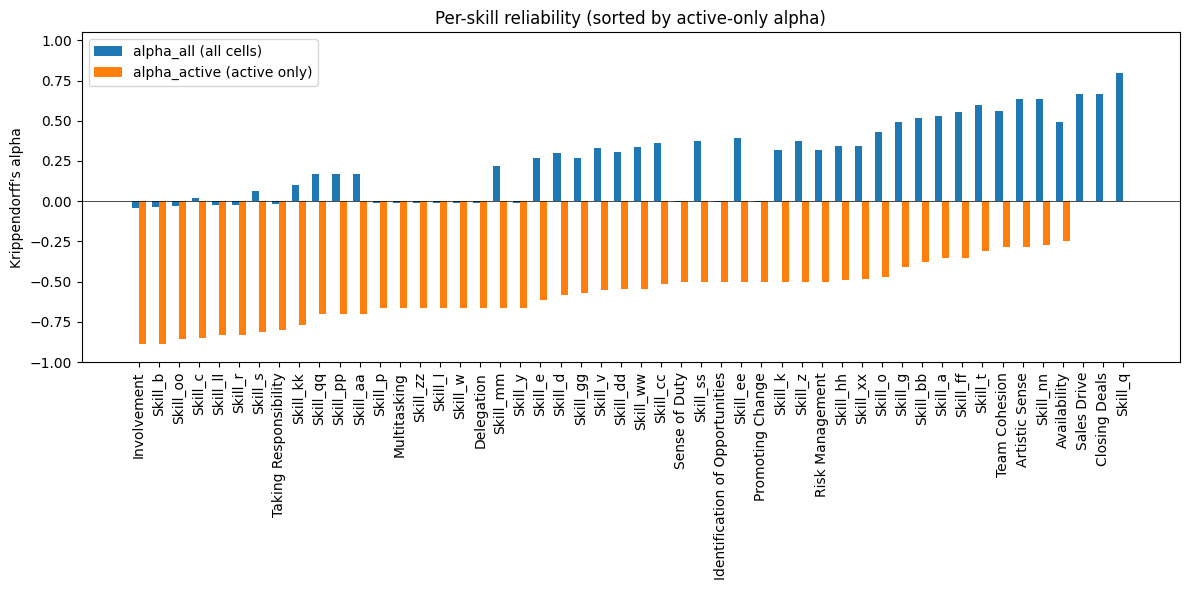

In [30]:
# Drop skills with NaN alpha_active (not enough active cases)
plot_df = per_skill_df.dropna(subset=["alpha_active_bc"]).copy()

# Sort by alpha_active (ascending = most difficult first)
plot_df = plot_df.sort_values("alpha_active_bc")
plot_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))

x = np.arange(len(plot_df))
width = 0.35

plt.bar(x - width/2, plot_df["alpha_all_bc"], width, label="alpha_all (all cells)")
plt.bar(x + width/2, plot_df["alpha_active_bc"], width, label="alpha_active (active only)")

plt.xticks(x, plot_df["skill"], rotation=90)
plt.ylabel("Krippendorff's alpha")
plt.title("Per-skill reliability (sorted by active-only alpha)")
plt.axhline(0, color="black", linewidth=0.5)
plt.ylim(-1, 1.05)   # Give more room below 0 so orange bars become visible
plt.legend()
plt.tight_layout()

plt.savefig("alpha_active_bc.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    hamming_loss, jaccard_score, cohen_kappa_score
)

# ====== CONFIG: paths to your three multihot files ======
# A and C are human groups; B is the LLM
CSV_A = "multihot_group1.csv"                     # Human A
CSV_B = "multihot_group2.csv"      # LLM
CSV_C = "labels_multi_hot_async_refined.csv"                     # Human C (new)

# ====== Load ======
A = pd.read_csv(CSV_A)
B = pd.read_csv(CSV_B)
C = pd.read_csv(CSV_C)

# ====== Identify multi-hot columns by name and intersect safely ======
mh_cols_A = sorted([c for c in A.columns if c.startswith("v_")])
mh_cols_B = sorted([c for c in B.columns if c.startswith("v_")])
mh_cols_C = sorted([c for c in C.columns if c.startswith("v_")])

# Use strict name intersection to avoid silent misalignment
mh_cols = sorted(set(mh_cols_A) & set(mh_cols_B) & set(mh_cols_C))
assert len(mh_cols) > 0, "No overlapping v_* columns across the three CSVs."

# ====== Align by expr_id and selected columns ======
AB = (A[["expr_id"] + mh_cols]
      .merge(B[["expr_id"] + mh_cols], on="expr_id", suffixes=("_A", "_B")))
AC = (A[["expr_id"] + mh_cols]
      .merge(C[["expr_id"] + mh_cols], on="expr_id", suffixes=("_A", "_C")))
BC = (B[["expr_id"] + mh_cols]
      .merge(C[["expr_id"] + mh_cols], on="expr_id", suffixes=("_B", "_C")))

assert len(AB) > 0 and len(AC) > 0 and len(BC) > 0, "Merges produced empty sets; check expr_id overlap."

def to_bin(mat: np.ndarray) -> np.ndarray:
    # Clamp to {0,1} robustly
    return (mat > 0).astype(int)

YA = to_bin(AB[[c + "_A" for c in mh_cols]].to_numpy())
YB = to_bin(AB[[c + "_B" for c in mh_cols]].to_numpy())

# For pairs not built from AB, rebuild views to keep identical ordering by expr_id
YA_for_AC = to_bin(AC[[c + "_A" for c in mh_cols]].to_numpy())
YC = to_bin(AC[[c + "_C" for c in mh_cols]].to_numpy())

YB_for_BC = to_bin(BC[[c + "_B" for c in mh_cols]].to_numpy())
YC_for_BC = to_bin(BC[[c + "_C" for c in mh_cols]].to_numpy())

# Sanity: shapes
n_AB, L = YA.shape
n_AC, L2 = YA_for_AC.shape
n_BC, L3 = YB_for_BC.shape
assert L == L2 == L3 == len(mh_cols)

# ====== Utility: compute the multi-label metrics for a pair (Y_true, Y_pred) ======
def multilabel_metrics(Y_true: np.ndarray, Y_pred: np.ndarray, label_names=None, pair_name=""):
    assert Y_true.shape == Y_pred.shape
    n, L = Y_true.shape

    # --- Global multi-label metrics ---
    # Micro (global) — standard headline metric for multi-label
    micro_p = precision_score(Y_true, Y_pred, average="micro", zero_division=0)
    micro_r = recall_score   (Y_true, Y_pred, average="micro", zero_division=0)
    micro_f1 = f1_score      (Y_true, Y_pred, average="micro", zero_division=0)

    # Hamming loss = average per-label error rate (lower = better)
    hamm = hamming_loss(Y_true, Y_pred)

    # Coverage for diagnostics (not “scores” but useful context)
    #  - per-sample union size fraction
    union_inst = (Y_true | Y_pred).sum(axis=1)
    coverage_ratio = float((union_inst / L).mean())
    #  - fraction of samples where either picked at least one label
    instance_coverage = float(((Y_true.sum(axis=1) > 0) | (Y_pred.sum(axis=1) > 0)).mean())

    # --- Per-label Cohen’s kappa (diagnostic, chance-corrected) ---
    kappas = []
    for j in range(L):
        try:
            k = cohen_kappa_score(Y_true[:, j], Y_pred[:, j])
        except Exception:
            k = np.nan
        kappas.append(k)
    kappas = np.array(kappas, dtype=float)

    kappa_summary = {
        "kappa_mean":        float(np.nanmean(kappas)),
        "kappa_median":      float(np.nanmedian(kappas)),
        "kappa_pct_ge_0.60": float(np.mean(kappas >= 0.60)),
        "kappa_pct_ge_0.80": float(np.mean(kappas >= 0.80)),
    }

    # Optional: per-label prevalence diagnostics
    prev_true = Y_true.mean(axis=0)
    prev_pred = Y_pred.mean(axis=0)
    per_label_df = pd.DataFrame({
        "label": label_names if label_names is not None else [f"v_{i}" for i in range(L)],
        "prevalence_true": prev_true,
        "prevalence_pred": prev_pred,
        "cohen_kappa": kappas,
    }).sort_values("cohen_kappa", ascending=True)

    summary = {
        "pair": pair_name,
        "n_samples": int(n),
        "n_labels": int(L),
        "micro_precision": micro_p,
        "micro_recall": micro_r,
        "micro_f1": micro_f1,
        "hamming_loss": hamm,
        "coverage_ratio": coverage_ratio,
        "instance_coverage": instance_coverage,
        **kappa_summary
    }

    return summary, per_label_df

# ====== Compute metrics ======
summary_A_vs_B, per_label_A_vs_B = multilabel_metrics(
    YA, YB, label_names=mh_cols, pair_name="HumanA vs HumanB"
)
summary_C_vs_B, per_label_C_vs_B = multilabel_metrics(
    YC_for_BC, YB_for_BC, label_names=mh_cols, pair_name="HumanB vs LLM"
)
summary_A_vs_C, per_label_A_vs_C = multilabel_metrics(
    YA_for_AC, YC, label_names=mh_cols, pair_name="HumanA vs LLM"
)

# ====== Print compact summaries ======
def print_summary(d):
    print(f"--- {d['pair']} ---")
    print(f"Samples: {d['n_samples']} | Labels: {d['n_labels']}")
    print(f"Micro  P/R/F1 : {d['micro_precision']:.4f} / {d['micro_recall']:.4f} / {d['micro_f1']:.4f}")
    print(f"Hamming Loss  : {d['hamming_loss']:.4f}")
    print(f"Coverage ratio: {d['coverage_ratio']:.4f} | Instance coverage: {d['instance_coverage']:.4f}")
    print(f"Cohen κ (mean/median): {d['kappa_mean']:.4f} / {d['kappa_median']:.4f} "
          f"| %κ≥0.60: {d['kappa_pct_ge_0.60']:.2%} | %κ≥0.80: {d['kappa_pct_ge_0.80']:.2%}")
    print()

print_summary(summary_A_vs_B)
print_summary(summary_C_vs_B)
print_summary(summary_A_vs_C)


--- HumanA vs HumanB ---
Samples: 115 | Labels: 63
Micro  P/R/F1 : 0.5504 / 0.5410 / 0.5456
Hamming Loss  : 0.0653
Coverage ratio: 0.1045 | Instance coverage: 0.9826
Cohen κ (mean/median): 0.3665 / 0.4230 | %κ≥0.60: 20.63% | %κ≥0.80: 3.17%

--- HumanB vs LLM ---
Samples: 115 | Labels: 63
Micro  P/R/F1 : 0.2965 / 0.6538 / 0.4080
Hamming Loss  : 0.0613
Coverage ratio: 0.0824 | Instance coverage: 0.9913
Cohen κ (mean/median): 0.2391 / 0.2015 | %κ≥0.60: 7.94% | %κ≥0.80: 0.00%

--- HumanA vs LLM ---
Samples: 115 | Labels: 63
Micro  P/R/F1 : 0.6667 / 0.2971 / 0.4111
Hamming Loss  : 0.0617
Coverage ratio: 0.0832 | Instance coverage: 0.9913
Cohen κ (mean/median): 0.2219 / 0.2100 | %κ≥0.60: 6.35% | %κ≥0.80: 0.00%



c:\Users\elena.rozera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\elena.rozera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:708: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\elena.rozera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\elena.rozera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:708: RuntimeWarning: invalid value 

In [35]:
import os

# ========= Create / choose results folder =========
RESULTS_DIR = "results"  # change if you want an absolute path
os.makedirs(RESULTS_DIR, exist_ok=True)

# ========= 1) Save GLOBAL summaries (one row per pair) =========
summary_df = pd.DataFrame([
    summary_A_vs_B,
    summary_C_vs_B,
    summary_A_vs_C,
])

summary_path = os.path.join(RESULTS_DIR, "multilabel_global_metrics.csv")
summary_df.to_csv(summary_path, index=False)
print("Saved global multi-label metrics to:", summary_path)

# ========= 2) Save PER-LABEL metrics for each pair =========
per_label_A_vs_B["pair"] = "HumanA vs HumanB"
per_label_C_vs_B["pair"] = "HumanB vs LLM"
per_label_A_vs_C["pair"] = "HumanA vs LLM"

per_label_all = pd.concat(
    [per_label_A_vs_B, per_label_C_vs_B, per_label_A_vs_C],
    ignore_index=True
)

per_label_path = os.path.join(RESULTS_DIR, "multilabel_per_label_metrics.csv")
per_label_all.to_csv(per_label_path, index=False)
print("Saved per-label multi-label metrics to:", per_label_path)

Saved global multi-label metrics to: results\multilabel_global_metrics.csv
Saved per-label multi-label metrics to: results\multilabel_per_label_metrics.csv


In [ ]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from typing import List, Tuple

# Mapping from skill names to indices (your referential)
REFERENTIAL_RAW = {
    ...
}

INDEX_TO_SKILL = {idx: name for name, idx in REFERENTIAL_RAW.items()}


def load_referential(path: str) -> pd.DataFrame:
    """
    Load referential and return a DataFrame with:
    - 'skill_idx' (1..63)
    - 'skill_name'
    - 'text' (name + definition) for TF-IDF.
    """
    df = pd.read_csv(path)
    print("Referential columns:", df.columns.tolist())
    
    # Try to guess which column holds the definition
    possible_def_cols = [
        'skill_definition', 'definition', 'description',
        'skill_desc', 'skillDescription'
    ]
    def_col = None
    for c in possible_def_cols:
        if c in df.columns:
            def_col = c
            break
    print("Using definition column:", def_col)
    
    rows = []
    for idx in range(1, 64):
        name = INDEX_TO_SKILL[idx]
        row = df[df['skill_name'] == name]
        if row.empty:
            raise ValueError(f"Skill '{name}' (idx={idx}) not found in referential CSV.")
        row = row.iloc[0]
        definition = str(row[def_col]) if def_col is not None else ""
        text = f"{name}. {definition}"
        rows.append({'skill_idx': idx, 'skill_name': name, 'text': text})
    
    return pd.DataFrame(rows)

ref_path = "soft_skills_referential.csv"
ref_df = load_referential(ref_path)
ref_df.head()

# Load SBERT model (downloaded the first time, then cached)
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

def build_skill_similarity_matrix_sbert(ref_df: pd.DataFrame,
                                        model: SentenceTransformer) -> np.ndarray:
    """
    Build a 63x63 cosine similarity matrix between skills using SBERT.
    """
    ref_sorted = ref_df.sort_values('skill_idx')
    texts = ref_sorted['text'].tolist()
    
    # Get normalized embeddings (L2)
    emb = model.encode(texts, normalize_embeddings=True)
    sim = cosine_similarity(emb)  # since normalized, this is just dot product
    return sim

sim_matrix = build_skill_similarity_matrix_sbert(ref_df, model)
sim_matrix.shape

pd.DataFrame(
    sim_matrix[:5, :5],
    index=ref_df.sort_values('skill_idx')['skill_name'].head(5),
    columns=ref_df.sort_values('skill_idx')['skill_name'].head(5)
)

def detect_skill_columns(df: pd.DataFrame, prefix: str = 'v_') -> List[str]:
    """
    Detect skill columns in a multi-hot file.
    Assumes columns are named like 'v_000', 'v_001', ...
    """
    skill_cols = [c for c in df.columns if c.startswith(prefix)]
    skill_cols = sorted(skill_cols)
    print(f"Detected {len(skill_cols)} skill columns with prefix '{prefix}'")
    return skill_cols

def load_multihot(path: str, prefix: str = 'v_') -> Tuple[pd.DataFrame, np.ndarray, List[str]]:
    """
    Load multi-hot file, detect skill columns, and return:
    - the full DataFrame
    - a numpy array of shape (n_samples, 63)
    - list of skill column names in order
    """
    df = pd.read_csv(path)
    skill_cols = detect_skill_columns(df, prefix=prefix)
    if len(skill_cols) != 63:
        raise ValueError(
            f"Expected 63 skill columns, found {len(skill_cols)}: {skill_cols}"
        )
    mat = df[skill_cols].values.astype(int)
    return df, mat, skill_cols

g1_path = "multihot_group1.csv"
g2_path = "multihot_group2.csv"
llm_path = "labels_multi_hot_async_refined.csv"

g1_df, g1_mat, g1_cols = load_multihot(g1_path)
g2_df, g2_mat, g2_cols = load_multihot(g2_path)
llm_df, llm_mat, llm_cols = load_multihot(llm_path)

print("Columns aligned?",
      g1_cols == g2_cols == llm_cols)


def get_disagreement_pairs(
    labels_A: np.ndarray,
    labels_B: np.ndarray,
    sim_matrix: np.ndarray
) -> List[Tuple[int, int, float]]:
    """
    Compute disagreement pairs between two annotators.

    labels_A, labels_B: shape (n_samples, 63), values {0,1}
    sim_matrix: shape (63,63), sim_matrix[i,j] in [0,1]

    Returns list of (idx_A, idx_B, similarity) where:
    - idx_A, idx_B are skill indices 1..63
    - similarity is sim_matrix[idx_A-1, idx_B-1]
    """
    n_samples, n_skills = labels_A.shape
    assert n_skills == 63

    pairs = []

    for i in range(n_samples):
        skills_A = set(np.where(labels_A[i] == 1)[0] + 1)  # 1-based
        skills_B = set(np.where(labels_B[i] == 1)[0] + 1)

        only_A = skills_A - skills_B
        only_B = skills_B - skills_A

        if not only_A or not only_B:
            continue

        # Pair skills in the smaller set with the most similar skill in the larger set
        if len(only_A) <= len(only_B):
            for idx_a in only_A:
                sims = [
                    (idx_b, sim_matrix[idx_a - 1, idx_b - 1])
                    for idx_b in only_B
                ]
                idx_b_best, sim_best = max(sims, key=lambda x: x[1])
                pairs.append((idx_a, idx_b_best, sim_best))
        else:
            for idx_b in only_B:
                sims = [
                    (idx_a, sim_matrix[idx_a - 1, idx_b - 1])
                    for idx_a in only_A
                ]
                idx_a_best, sim_best = max(sims, key=lambda x: x[1])
                pairs.append((idx_a_best, idx_b, sim_best))

    return pairs


def sample_random_pairs(
    sim_matrix: np.ndarray,
    n_pairs: int,
    random_state: int = 0
) -> List[Tuple[int, int, float]]:
    """
    Sample `n_pairs` random distinct skill pairs (i != j) and return
    list of (idx_i, idx_j, similarity).
    """
    rng = np.random.default_rng(random_state)
    pairs = []
    n_skills = sim_matrix.shape[0]

    for _ in range(n_pairs):
        i, j = rng.choice(n_skills, size=2, replace=False)
        sim = sim_matrix[i, j]
        pairs.append((i + 1, j + 1, sim))  # 1-based indices

    return pairs


def describe_similarity_distribution(
    sims: np.ndarray,
    label: str
    ) -> None:
    """
    Print summary statistics for a similarity array.
    """
    print(f"\n=== Similarity stats: {label} ===")
    print(f"n = {len(sims)}")
    print(f"mean   = {sims.mean():.4f}")
    print(f"median = {np.median(sims):.4f}")
    print(f"std    = {sims.std(ddof=1):.4f}")
    for p in [0.75, 0.90, 0.95]:
        print(f"{int(p*100)}th pct = {np.quantile(sims, p):.4f}")

    for thr in [0.1, 0.2, 0.3, 0.4]:
        prop = (sims > thr).mean()
        print(f"prop(sim > {thr:.1f}) = {prop:.3f}")


def cohen_d(x: np.ndarray, y: np.ndarray) -> float:
    """
    Cohen's d: effect size for difference of means between two samples.
    """
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled_var = ((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2)
    return (x.mean() - y.mean()) / np.sqrt(pooled_var)


def show_top_pairs(
    pairs: List[Tuple[int, int, float]],
    ref_df: pd.DataFrame,
    k: int = 10,
    title: str = "Top disagreement pairs"
) -> None:
    """
    Print top-k pairs with highest similarity.
    """
    print(f"\n=== {title} (k={k}) ===")
    pairs_sorted = sorted(pairs, key=lambda t: t[2], reverse=True)[:k]
    idx_to_name = {
        row['skill_idx']: row['skill_name']
        for _, row in ref_df.iterrows()
    }
    for idx_a, idx_b, sim in pairs_sorted:
        name_a = idx_to_name[idx_a]
        name_b = idx_to_name[idx_b]
        print(f"{name_a:30s}  <->  {name_b:30s} | sim={sim:.3f}")


# Human–Human
hh_pairs = get_disagreement_pairs(g1_mat, g2_mat, sim_matrix)
hh_sims = np.array([p[2] for p in hh_pairs], dtype=float)

# Human–LLM
hl_pairs = get_disagreement_pairs(g1_mat, llm_mat, sim_matrix)
hl_sims = np.array([p[2] for p in hl_pairs], dtype=float)

len(hh_pairs), len(hl_pairs)

# Random baselines
hh_random_pairs = sample_random_pairs(sim_matrix, n_pairs=len(hh_pairs), random_state=42)
hl_random_pairs = sample_random_pairs(sim_matrix, n_pairs=len(hl_pairs), random_state=123)

hh_random_sims = np.array([p[2] for p in hh_random_pairs], dtype=float)
hl_random_sims = np.array([p[2] for p in hl_random_pairs], dtype=float)

# Descriptive stats
describe_similarity_distribution(hh_sims, "Human–Human disagreement pairs")
describe_similarity_distribution(hh_random_sims, "Random skill pairs (baseline) for Human–Human")

describe_similarity_distribution(hl_sims, "Human–LLM disagreement pairs")
describe_similarity_distribution(hl_random_sims, "Random skill pairs (baseline) for Human–LLM")

print("\n=== Effect sizes (Cohen's d) ===")
d_hh = cohen_d(hh_sims, hh_random_sims)
d_hl = cohen_d(hl_sims, hl_random_sims)
print(f"Human–Human vs random: d = {d_hh:.3f}")
print(f"Human–LLM  vs random: d = {d_hl:.3f}")

Referential columns: ['vector_idx', 'group_id', 'group_name', 'skill_id', 'skill_name', 'skill_definition']
Using definition column: skill_definition
Detected 63 skill columns with prefix 'v_'
Detected 63 skill columns with prefix 'v_'
Detected 63 skill columns with prefix 'v_'
Columns aligned? True

=== Similarity stats: Human–Human disagreement pairs ===
n = 138
mean   = 0.5389
median = 0.5294
std    = 0.0848
75th pct = 0.5969
90th pct = 0.6526
95th pct = 0.6866
prop(sim > 0.1) = 1.000
prop(sim > 0.2) = 1.000
prop(sim > 0.3) = 1.000
prop(sim > 0.4) = 0.949

=== Similarity stats: Random skill pairs (baseline) for Human–Human ===
n = 138
mean   = 0.4205
median = 0.4109
std    = 0.1076
75th pct = 0.4914
90th pct = 0.5641
95th pct = 0.6046
prop(sim > 0.1) = 1.000
prop(sim > 0.2) = 1.000
prop(sim > 0.3) = 0.870
prop(sim > 0.4) = 0.558

=== Similarity stats: Human–LLM disagreement pairs ===
n = 72
mean   = 0.5358
median = 0.5184
std    = 0.0992
75th pct = 0.6082
90th pct = 0.6521
95th pct 